# keras実験

## 問題
- kerasの実行時間が段々と延びる問題
    - 最初は数秒で終わっていたkerasのfitが、そのうち数分、數十分かかるようになる
        - 半日以上実行しても、グリッドサーチが終わらなくなる・・・

## 実験
- ソースコードは、day3課題からkeras部分だけ抽出して実験
- 処理を繰り返すうちに、pythonにメモリを食われてしまい、足りなくなっていると推測
    - macのアクティビティモニタを確認したところ、notebook実行前は無かった「プロセス名:python」が「メモリ:4.18GB」となってる
    - 実行が終えても「メモリ:4.18GB」が消えることなく、残ったままになってた
    - 再実行すると、０から段々増えていき、最終的に4.18まで増える
    - notebookを終了させると「プロセス名:python」、「メモリ:4.18GB」は無くなる
    - kerasをコメントアウトして実行したday3課題.jpynbは完了後200MBだった
    - 手動でfitしたmodelをdelしてみたが、効果は無かった
    - 下記サイトの方法でメモリを使っている変数を調べてみたが、 kerasをコメントアウトして実行したday3課題の方が使用量は多かった
        - ->ということは自前の変数は悪さはしていないはず
        - https://qiita.com/AnchorBlues/items/883790e43417640140

### 変数のメモリ使用量調査結果
* keras

|            Variable Name|    Memory|
|:-----------|------------:|
|                  df_data|     28040|

* kerasをコメントアウトしたday3課題

|            Variable Name|    Memory|
 |:-----------|------------:| 
|                  df_data|     28040|
|      selected_train_data|     19892|
|               train_data|     24936|



## 分かったこと
    - keras本体がメモリを食っている
    - 実装が悪いわけでは無いが、for文で繰り返し実行し過ぎていると思われる
    - 対策としてはfor文を止めて、出来るだけ少ない回数でfitするしかなさそう
    - とはいえ、day3課題.jpynbの今の作りを変えるのはコストがかかりすぎる為、対応は次期検討事項とする

## ソースコード

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils

from tqdm import tqdm_notebook as tqdm

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# ワーニングを消すおまじない。課題提出時だけ有効にする
import warnings
warnings.filterwarnings('ignore')

In [3]:
# データ読み取り
df_data = pd.read_csv('./data/measurements.csv')

### データの整形

In [4]:
# 小数点表示を','から'.'に変更
df_data = df_data.replace('\,', '.', regex=True)

# 文字列から数値に変換
df_data['distance'] = df_data['distance'].astype(float)
df_data['consume'] = df_data['consume'].astype(float)
df_data['speed'] = df_data['speed'].astype(float)
df_data['temp_inside'] = df_data['temp_inside'].astype(float)
df_data['temp_outside'] = df_data['temp_outside'].astype(float)
df_data['refill liters'] = df_data['refill liters'].astype(float)

# 'SP98':0, 'E10':1に変換
df_data.loc[df_data['gas_type'] == 'SP98', 'gas_type'] = 0
df_data.loc[df_data['gas_type'] == 'E10', 'gas_type'] = 1
df_data.loc[df_data['refill gas'] == 'SP98', 'refill gas'] = 0
df_data.loc[df_data['refill gas'] == 'E10', 'refill gas'] = 1

In [5]:
# '大文字小文字がバラバラなのでAC'と'sun'に統一
df_data.loc[df_data['specials'] == 'Sun', 'specials'] = 'sun'
df_data.loc[df_data['specials'] == 'ac', 'specials'] = 'AC'
df_data.loc[df_data['specials'] == 'AC Sun', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'sun ac', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'ac rain', 'specials'] = 'AC rain'

In [6]:
# 'specials’をダミー変数に置き換え
df_specials = pd.get_dummies(df_data['specials'])
df_specials.columns = [
    '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun', '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'
]
df_data = pd.concat([df_data, df_specials], axis=1)

# ダミー変数に置き換えたので'specials'は削除
df_data = df_data.drop(['specials'], axis=1)

In [7]:
# 暖房がまったく使用されなかった場合はフラグを立てる説明変数を作成
df_data['heating_off'] = df_data['temp_inside'].isnull()
df_data['heating_off'] = df_data['heating_off'].apply(float)

# 加熱が完全に止まったら、内部温度を外気温度
df_data['temp_inside'].fillna(df_data['temp_outside'], inplace=True)

# 'refill liters','refil gas'は欠損値多すぎるので削除
df_data = df_data.drop('refill liters', axis=1)
df_data = df_data.drop('refill gas', axis=1)

In [8]:
# 差分があった。どちらかに漏れがある可能性があるので、「and」を取り、確実なデータのみ抽出した'[new]XXX'を新規に作成する
df_data['[new]AC'] = (df_data['AC'] & df_data['[s]AC'])
df_data['[new]rain'] = (df_data['rain'] & df_data['[s]rain'])
df_data['[new]sun'] = (df_data['sun'] & df_data['[s]sun'])

In [9]:
# temp_insideとtemp_outsideは同じ温度を表しているので関連性がありそう。差分を取り、新たな説明変数とする
df_data['temp_diff'] = df_data['temp_inside'] - df_data['temp_outside']

# distanceとspeedから乗車時間が作れるので新たな説明変数とする
df_data['time_h'] = df_data['distance'] / df_data['speed']

In [10]:
# 型の統一（量的変数はfloat64、質的変数はuint8）
df_data['gas_type'] = df_data['gas_type'].astype('uint8')
df_data['AC'] = df_data['AC'].astype('uint8')
df_data['rain'] = df_data['rain'].astype('uint8')
df_data['sun'] = df_data['sun'].astype('uint8')
df_data['heating_off'] = df_data['heating_off'].astype('uint8')
df_data['[new]AC'] = df_data['[new]AC'].astype('uint8')
df_data['[new]rain'] = df_data['[new]rain'].astype('uint8')
df_data['[new]sun'] = df_data['[new]sun'].astype('uint8')

### グラフを可視化

In [11]:
# 'consume'に絞って、相関係数、ヒートマップを可視化
consume_corr = df_data.corr()['consume']

# 相関係数の絶対値でソート
sorted_consume_corr = abs(consume_corr).sort_values(ascending=True)

### 検証

In [12]:
def get_quantitative_var_flg(df_data, columns):
    """量的変数フラグ取得"""
    
    quantitative_var_flg = []
    
    for column in columns:
        if (df_data[column].dtypes == 'float64'):
            quantitative_var_flg.append(True)
        else:
            quantitative_var_flg.append(False)
            
#     print(quantitative_var_flg)
    return quantitative_var_flg

In [13]:
def decorrelation_data(data, calc_S_flg=True, S=None):
    """無相関化"""
    
    if calc_S_flg:
        # 分散・共分散を求める
        cov = np.cov(data, rowvar=0)

        # 分散共分散行列の固有ベクトルを用いて
        _, S = np.linalg.eig(cov)

    # データを無相関化
    data_decorr = np.dot(S.T, data.T).T

    return data_decorr, S

In [14]:
def pre_process_for_divided_data(X_train, X_test, quantitative_var_flg):
    """X_train, X_testに対する前処理"""

    if X_train.shape[1] >= 2 and X_test.shape[1] >= 2:
        # 無相関化(X_train, X_test)・・・SはX_trainで計算したものを使う
        X_train, S = decorrelation_data(X_train)
        X_test, _ = decorrelation_data(X_test, calc_S_flg=False, S=S)

# # 量的変数だけ無相関化する処理
# 試してみたところ精度が上がらなかったのでコメントアウト
#         # 無相関化(X_train, X_test)・・・SはX_trainで計算したものを使う
#         X_train_non_corr, S = decorrelation_data(X_train)
#         X_test_non_corr, _ = decorrelation_data(X_test, calc_S_flg=False, S=S)

#         # 量的変数だけ無相関化
#         for cnt, flg in enumerate(quantitative_var_flg):
#             if flg:
#                 X_train[cnt] = X_train_non_corr[cnt]
#                 X_test[cnt] = X_test_non_corr[cnt]

    # 正規化
    normsc = MinMaxScaler()
    X_train = normsc.fit_transform(X_train)
    X_test = normsc.transform(X_test)

# # 量的変数だけ正規化する処理
# 試してみたところ精度が上がらなかったのでコメントアウト
#     normsc = MinMaxScaler()
#     X_train_nrm = normsc.fit_transform(X_train.copy())
#     X_test_nrm = normsc.transform(X_test.copy())

#     # 量的変数だけ正規化
#     for cnt, flg in enumerate(quantitative_var_flg):
#         if flg:
#             X_train[cnt] = X_train_nrm[cnt]
#             X_test[cnt] = X_test_nrm[cnt]

    # 標準化
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_test = stdsc.transform(X_test)

# # 量的変数だけ標準化する処理
# 試してみたところ精度が上がらなかったのでコメントアウト
#     stdsc = StandardScaler()
#     X_train_std = stdsc.fit_transform(X_train.copy())
#     X_test_std = stdsc.transform(X_test.copy())

#     # 量的変数だけ標準化
#     for cnt, flg in enumerate(quantitative_var_flg):
#         if flg:
#             X_train[cnt] = X_train_std[cnt]
#             X_test[cnt] = X_test_std[cnt]

    return X_train, X_test

In [15]:
def train_test_split_for_comparison(X, y):
    """
    受講者間のスコア比較用処理
    returnで返すX_test, y_testは、
    最後にMAE等の指標を測定する時のみ用いる。
    """

    test_size = 0.1

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1234
    )
    
    return X_train, X_test, y_train, y_test

In [16]:
def evaluate_cross_varidation(X, y, model, quantitative_var_flg, pre_process_flg=True):
    """クロスバリデーション法"""
    
    # 受講者間のスコア比較用処理
    X_train_for_comp, X_test_for_comp, y_train_for_comp, y_test_for_comp = train_test_split_for_comparison(X, y)

    if pre_process_flg:
        # X_train, X_testに対する前処理
        X_train_for_comp, X_test_for_comp = pre_process_for_divided_data(X_train_for_comp, X_test_for_comp, quantitative_var_flg)

    # グループ数を設定（今回は5分割）
    n_split = 5

    # テスト役を交代させながら学習と評価を繰り返す
    cross_valid_mae = 0
#     split_num = 1
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train_for_comp, y_train_for_comp):
        X_train, y_train = X_train_for_comp[train_idx], y_train_for_comp[train_idx]
        X_test, y_test = X_train_for_comp[test_idx], y_train_for_comp[test_idx]

        # 学習用データを使ってモデルを学習
        fit_result = model.fit(X_train, y_train, validation_data=(X_test, y_test))

        # テストデータに対する予測を実行
        y_pred_test = model.predict(X_test_for_comp)

        # テストデータに対するMAEを計算
        mae_fold = mean_absolute_error(y_test_for_comp, y_pred_test)
#         print("Fold{} MAE = {}".format(split_num, round(mae_fold, 3)))

        # 後で平均を取るためにMAEを加算
        cross_valid_mae += mae_fold
#         split_num += 1

    # MAEの平均値を最終的な汎化誤差値とする
    final_cv_mae = cross_valid_mae / n_split

    print("Cross Validation MAE = {}".format(round(final_cv_mae, 3)))
    
    # 各epochにおける損失と精度をグラフ化してみる
    df = pd.DataFrame(fit_result.history)

    df[["loss", "val_loss"]].plot()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title('[CV]epock X loss')
    plt.show()

    # 明示的にモデルをdel
    del model

    return final_cv_mae

In [17]:
def evaluate_grid_search(X, y, model, parameters, quantitative_var_flg, pre_process_flg=True):
    """グリッドサーチ法"""
    
    # 受講者間のスコア比較用処理
    X_train_for_comp, X_test_for_comp, y_train_for_comp, y_test_for_comp = train_test_split_for_comparison(X, y)

    if pre_process_flg:
        # X_train, X_testに対する前処理
        X_train_for_comp, X_test_for_comp = pre_process_for_divided_data(X_train_for_comp, X_test_for_comp, quantitative_var_flg)

    # グループ数を設定（今回は5分割）
    n_split = 5

    # グリッドサーチで最適なパラメタを見つける＆用いて識別する
    est = GridSearchCV(model, parameters, cv=n_split)
    est.fit(X_train_for_comp, y_train_for_comp, validation_data=(X_test_for_comp, y_test_for_comp))

    final_gs_best_params = est.best_params_
    final_gs_best_score = est.best_score_

    # 訓練データに対する予測を実行
    y_pred_train = est.predict(X_train_for_comp)

    # 訓練データに対するMAEを計算
    final_gs_pred_mae = mean_absolute_error(y_train_for_comp, y_pred_train)

    # テストデータに対する予測を実行
    y_pred_test = est.predict(X_test_for_comp)

    # テストデータに対するMAEを計算
    final_gs_mae = mean_absolute_error(y_test_for_comp, y_pred_test)

    print("best params = {}".format(final_gs_best_params))
    print("best score = {}".format(final_gs_best_score))
    print("Grid Search pred MAE = {}".format(round(final_gs_pred_mae, 3)))
    print("Grid Search MAE = {}".format(round(final_gs_mae, 3)))

    # 明示的にモデルをdel
    del model

    return final_gs_mae, final_gs_pred_mae, final_gs_best_params, final_gs_best_score

#### 評価したいモデルとパラメタを設定

In [18]:
def get_evaluate_models_and_params(input_dim):
    """モデルとパラメタの設定"""
    
    evaluate_models = {}

    # keras
    def reg_model(out_dim=10, activation='relu', optimizer='adam', hidden_cnt=10):
        """keras用回帰モデル"""
        
        model = Sequential()
        
        model.add(Dense(out_dim, input_dim=input_dim, activation=activation))
        for i in range(hidden_cnt):
            model.add(Dense(out_dim, activation=activation))
        model.add(Dense(1))
        
        model.compile(loss='mean_absolute_error', optimizer=optimizer)
        return model

    evaluate_models['KerasRegressor'] = {
        'model': KerasRegressor(
            build_fn=reg_model,
            epochs=20, 
            batch_size=10, 
            verbose=0
        ),
        'parameters': {
#             'activation': ['relu', 'sigmoid'], 
#             'optimizer': ['adam', 'adagrad'], 
            
#             'activation': ['relu'], 
#             'optimizer': ['adam'], 
            
#             'out_dim': [10, 20],
#             'nb_epoch': [20, 100], 
#             'batch_size': [5, 10],
#             'hidden_cnt': [1, 10]
        },
        'pre_process_flg': True,
    }

    return evaluate_models

### 特徴選択-相関係数の値で説明変数を選択する方法(normal法)
consumeとの相関係数（の絶対値）が大きいデータを選択すれば一般的には問題なさそうだが、念の為、最初は説明変数全てを選択し、徐々に説明変数の数を減らしながら精度を計測してみた。
#### モデルの学習と評価


0 Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.643


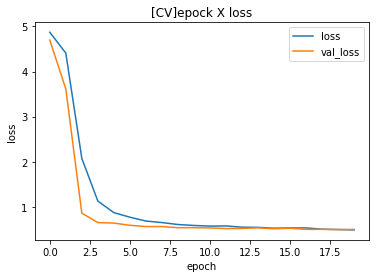

best params = {}
best score = -0.6318922857500421
Grid Search pred MAE = 0.432
Grid Search MAE = 0.673

1 Index(['gas_type', '[s]snow', 'temp_inside', '[s]AC sun', '[new]AC', '[s]AC',
       'heating_off', '[s]AC rain', 'AC', '[s]AC snow', 'distance', '[s]rain',
       '[new]rain', '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain',
       'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.706


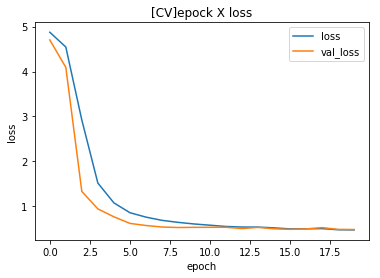

best params = {}
best score = -0.6021152257406951
Grid Search pred MAE = 0.489
Grid Search MAE = 0.679

2 Index(['[s]snow', 'temp_inside', '[s]AC sun', '[new]AC', '[s]AC',
       'heating_off', '[s]AC rain', 'AC', '[s]AC snow', 'distance', '[s]rain',
       '[new]rain', '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain',
       'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.635


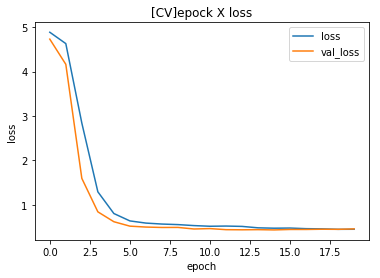

best params = {}
best score = -0.6360075564302483
Grid Search pred MAE = 0.479
Grid Search MAE = 0.591

3 Index(['temp_inside', '[s]AC sun', '[new]AC', '[s]AC', 'heating_off',
       '[s]AC rain', 'AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain',
       '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.635


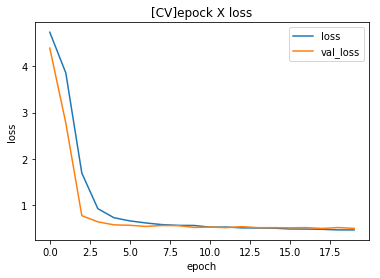

best params = {}
best score = -0.6032424900456622
Grid Search pred MAE = 0.458
Grid Search MAE = 0.631

4 Index(['[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.681


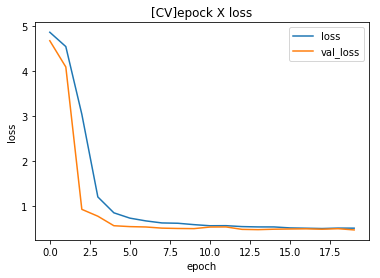

best params = {}
best score = -0.5329024871987394
Grid Search pred MAE = 0.433
Grid Search MAE = 0.557

5 Index(['[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC', '[s]AC snow',
       'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun', 'sun',
       'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.652


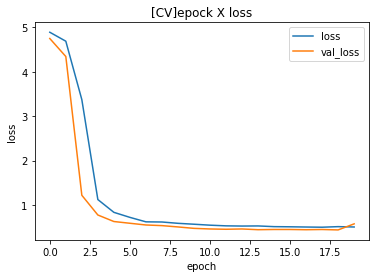

best params = {}
best score = -0.6055441580734143
Grid Search pred MAE = 0.466
Grid Search MAE = 0.724

6 Index(['[s]AC', 'heating_off', '[s]AC rain', 'AC', '[s]AC snow', 'distance',
       '[s]rain', '[new]rain', '[s]sun', '[new]sun', 'sun', 'time_h', 'speed',
       'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.663


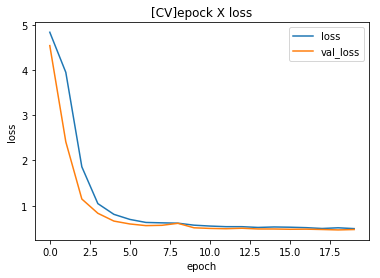

best params = {}
best score = -0.5451310984043132
Grid Search pred MAE = 0.462
Grid Search MAE = 0.69

7 Index(['heating_off', '[s]AC rain', 'AC', '[s]AC snow', 'distance', '[s]rain',
       '[new]rain', '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain',
       'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.651


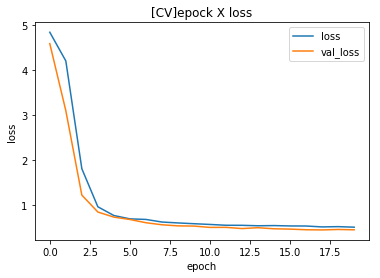

best params = {}
best score = -0.5714127385513831
Grid Search pred MAE = 0.445
Grid Search MAE = 0.575

8 Index(['[s]AC rain', 'AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain',
       '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.646


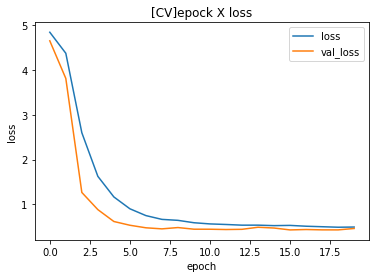

best params = {}
best score = -0.5703542596289627
Grid Search pred MAE = 0.481
Grid Search MAE = 0.594

9 Index(['AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun',
       '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.617


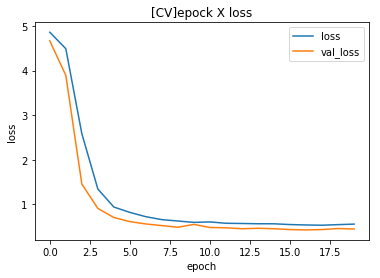

best params = {}
best score = -0.5621666505206964
Grid Search pred MAE = 0.459
Grid Search MAE = 0.631

10 Index(['[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.646


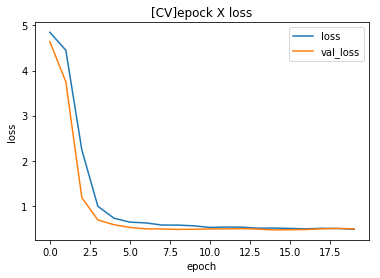

best params = {}
best score = -0.5779548430852699
Grid Search pred MAE = 0.455
Grid Search MAE = 0.574

11 Index(['distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun', 'sun',
       'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 1.373


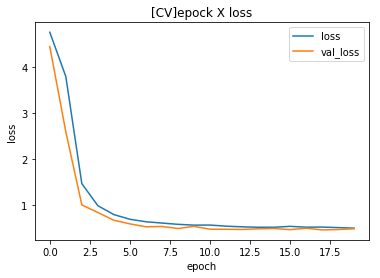

best params = {}
best score = -0.5556948492383547
Grid Search pred MAE = 0.474
Grid Search MAE = 0.652

12 Index(['[s]rain', '[new]rain', '[s]sun', '[new]sun', 'sun', 'time_h', 'speed',
       'rain', 'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.664


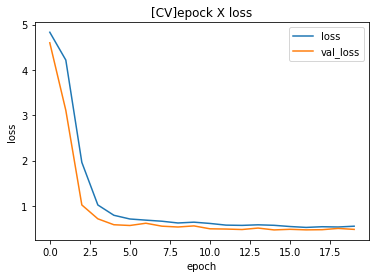

best params = {}
best score = -0.5853211802876098
Grid Search pred MAE = 0.494
Grid Search MAE = 0.605

13 Index(['[new]rain', '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain',
       'temp_diff', 'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.676


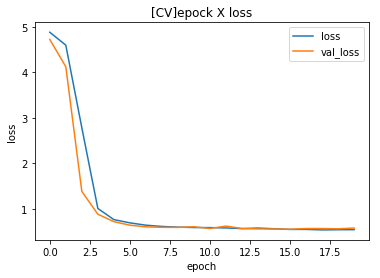

best params = {}
best score = -0.5668129478621278
Grid Search pred MAE = 0.506
Grid Search MAE = 0.678

14 Index(['[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.569


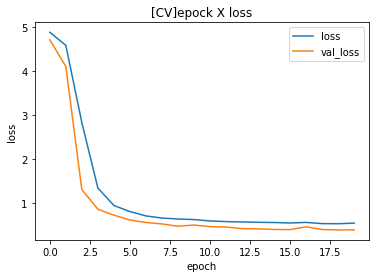

best params = {}
best score = -0.5582300496306324
Grid Search pred MAE = 0.536
Grid Search MAE = 0.632

15 Index(['[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.609


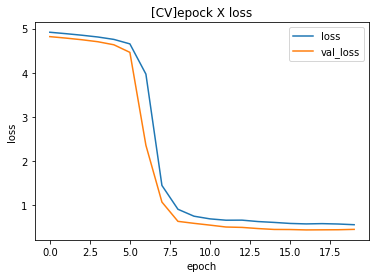

best params = {}
best score = -0.5623335183349927
Grid Search pred MAE = 0.475
Grid Search MAE = 0.612

16 Index(['sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'], dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.61


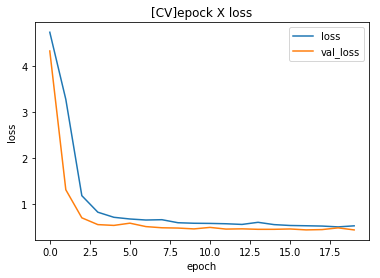

best params = {}
best score = -0.5561328718177228
Grid Search pred MAE = 0.517
Grid Search MAE = 0.63

17 Index(['time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'], dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.606


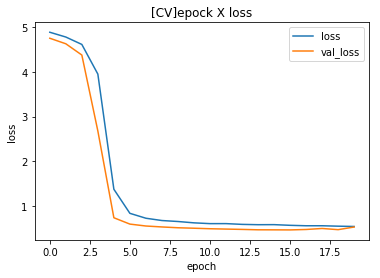

best params = {}
best score = -0.5828412015492732
Grid Search pred MAE = 0.521
Grid Search MAE = 0.643

18 Index(['speed', 'rain', 'temp_diff', 'temp_outside'], dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.61


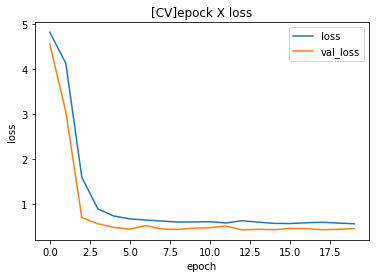

best params = {}
best score = -0.5682081689465694
Grid Search pred MAE = 0.548
Grid Search MAE = 0.587

19 Index(['rain', 'temp_diff', 'temp_outside'], dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.667


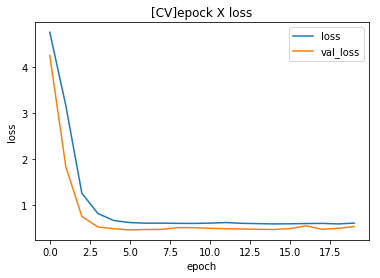

best params = {}
best score = -0.6034255500850841
Grid Search pred MAE = 0.556
Grid Search MAE = 0.674

20 Index(['temp_diff', 'temp_outside'], dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.699


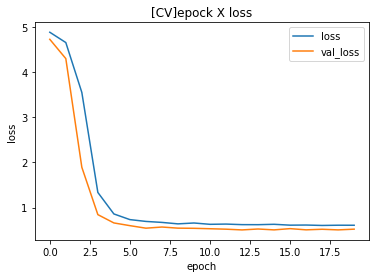

best params = {}
best score = -0.6187268089086757
Grid Search pred MAE = 0.574
Grid Search MAE = 0.692

21 Index(['temp_outside'], dtype='object')

< KerasRegressor >
Cross Validation MAE = 0.684


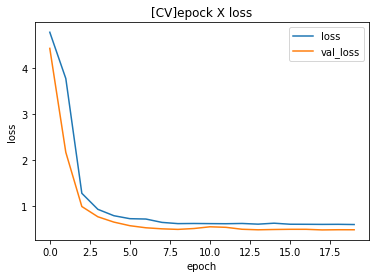

best params = {}
best score = -0.6127663287187374
Grid Search pred MAE = 0.585
Grid Search MAE = 0.684

CPU times: user 2h 13min 33s, sys: 4min 47s, total: 2h 18min 20s
Wall time: 3h 54min 1s


In [19]:
%%time
# 相関係数の値で説明変数を選択する方法を使って、各モデルを学習・評価

final_cv_mae = {}
final_gs_best_params, final_gs_best_score, final_gs_mae, final_gs_pred_mae = {}, {}, {}, {}
final_exp_data = {}

# 最初は説明変数全てを選択し、徐々に数を減らしながら精度を計測
exp_data = sorted_consume_corr
for exp_num in tqdm(range(len(exp_data) - 1)):
    if exp_num == 0:
        exp_data = exp_data.drop('consume')
    else:
        exp_data = exp_data.drop(exp_data.index[0])

    print('\n{} {}'.format(exp_num, exp_data.index))
    
    X = df_data[exp_data.index].values
    y = df_data['consume'].values

    cv_mae = {}
    gs_best_params, gs_best_score, gs_mae, gs_pred_mae = {}, {}, {}, {}

    # 量的データフラグ取得
    quantitative_var_flg = get_quantitative_var_flg(df_data, exp_data.index)
    
    # モデルとパラメタの設定
    evaluate_models = get_evaluate_models_and_params(len(exp_data))
    
    # evaluate_modelsに設定したモデルを順番に評価
    # グリッドサーチ以外はパラメタはデフォルト値
    for key, model in evaluate_models.items():
        print('\n<', key, '>')

        # クロスバリデーション法
        cv_mae[key] = evaluate_cross_varidation(
            X, y, model['model'], quantitative_var_flg, model['pre_process_flg']
        )

# これを有効にすると時間がかかりすぎる
        # グリッドサーチ法
        gs_mae[key], gs_pred_mae[key], gs_best_params[key], gs_best_score[key] = evaluate_grid_search(
            X, y, model['model'], model['parameters'], quantitative_var_flg, model['pre_process_flg']
        )

#         # keras対策
#         # kerasはグリッドサーチしない。ベストパラメタは別で見つけたものを使う
#         # そのためクロスバリデーションと値は同じになる
#         if key != 'KerasRegressor':
#             # グリッドサーチ法
#             gs_mae[key], gs_pred_mae[key], gs_best_params[key], gs_best_score[key] = evaluate_grid_search(
#                 X, y, model['model'], model['parameters'], quantitative_var_flg, model['pre_process_flg']
#             )
#         else:
#             print('[注意！]KerasRegressorのgs_maeは計測に時間がかかるためスキップ。gs_maeはcv_maeの値を入れておく')
#             gs_mae[key], gs_pred_mae[key], gs_best_params[key], gs_best_score[key] = cv_mae[key], 0, 0, 0

    # 結果を保持
    final_cv_mae[exp_num] = cv_mae
    final_gs_mae[exp_num], final_gs_pred_mae[exp_num], final_gs_best_params[exp_num], final_gs_best_score[exp_num] = gs_mae, gs_pred_mae, gs_best_params, gs_best_score
    final_exp_data[exp_num] = exp_data

#### 定性評価

In [20]:
# データが尖ってる場合、グラフで比較出来ないので、指定数以上の誤差は仮の値にする
comp_error_list = [
    final_cv_mae,
    final_gs_mae,
    final_gs_pred_mae
]

for i, models_error in enumerate(comp_error_list):
    for j in final_cv_mae:
        for model, error in models_error[j].items():
            if error >= 1.0:
                print(i, j, model, error)
                models_error[j][model] = 1.0

0 11 KerasRegressor 1.3730324854606235


In [21]:
# モデルの精度
model_str_list = [
    'KerasRegressor',
]

kerasregressor_cv_mae = {}
kerasregressor_gs_mae = {}
kerasregressor_gs_pred_mae = {}

comp_cv_model_list = [
    kerasregressor_cv_mae,
]

comp_gs_model_list = [
    kerasregressor_gs_mae,
]

comp_gs_pred_model_list = [
    kerasregressor_gs_pred_mae,
]

for i in final_cv_mae:
    # クロスバリデーション法
    for idx, model in zip(model_str_list, comp_cv_model_list):
        model[i] = [
            v for k, v in final_cv_mae[i].items() if k == idx
        ]

    # グリッドサーチ法
    for idx, model in zip(model_str_list, comp_gs_model_list):
        model[i] = [
            v for k, v in final_gs_mae[i].items() if k == idx
        ]
        
    # グリッドサーチ法(訓練誤差)
    for idx, model in zip(model_str_list, comp_gs_pred_model_list):
        model[i] = [
            v for k, v in final_gs_pred_mae[i].items() if k == idx
        ]

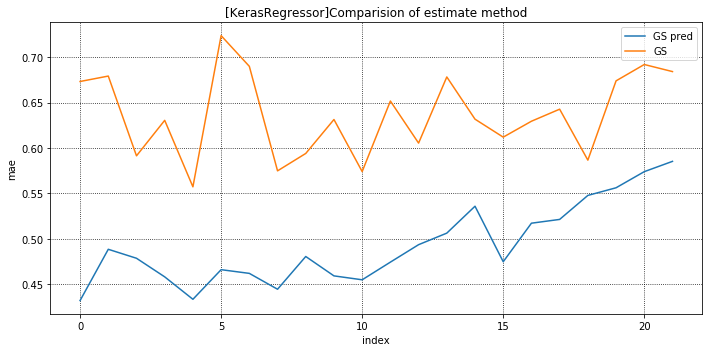

In [22]:
# グラフによる訓練誤差・汎化誤差の比較
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_title('[KerasRegressor]Comparision of estimate method')
ax.plot(kerasregressor_gs_pred_mae.keys(), kerasregressor_gs_pred_mae.values(), label='GS pred')
ax.plot(kerasregressor_gs_mae.keys(), kerasregressor_gs_mae.values(), label='GS')

ax.set_xlabel('index')
ax.set_ylabel('mae')
ax.grid(which='major', color='black', linestyle=':')
ax.grid(which='minor', color='black', linestyle=':')
ax.legend()
    
fig.tight_layout()
fig.show()

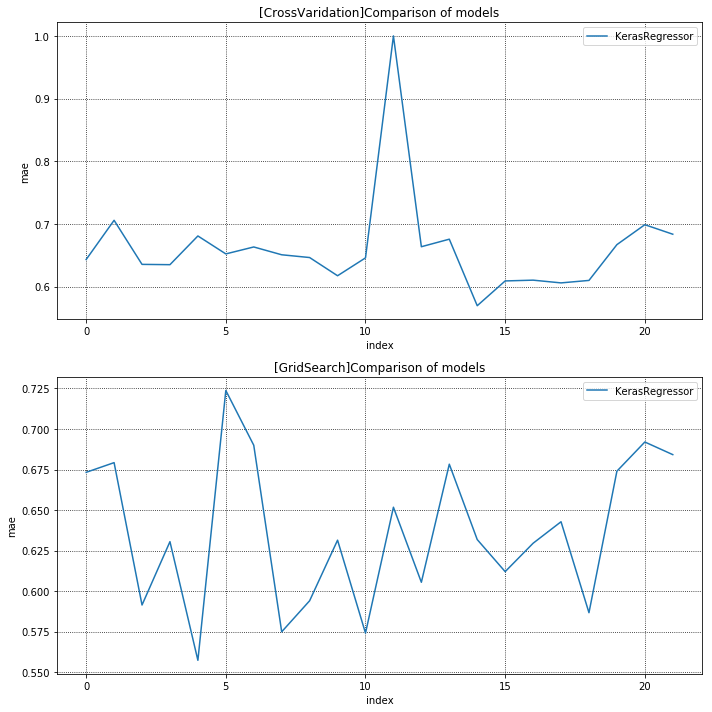

In [23]:
# グラフによるモデルの比較
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# モデルの比較（クロスバリデーション法）
ax[0].set_title('[CrossVaridation]Comparison of models')
ax[0].plot(kerasregressor_cv_mae.keys(), 
           kerasregressor_cv_mae.values(), label='KerasRegressor')

# モデルの比較（グリッドサーチ法）
ax[1].set_title('[GridSearch]Comparison of models')
ax[1].plot(kerasregressor_gs_mae.keys(), 
           kerasregressor_gs_mae.values(), label='KerasRegressor')

for i in range(2):
    ax[i].set_xlabel('index')
    ax[i].set_ylabel('mae')
    ax[i].grid(which='major', color='black', linestyle=':')
    ax[i].grid(which='minor', color='black', linestyle=':')
    ax[i].legend()

fig.tight_layout()
fig.show()

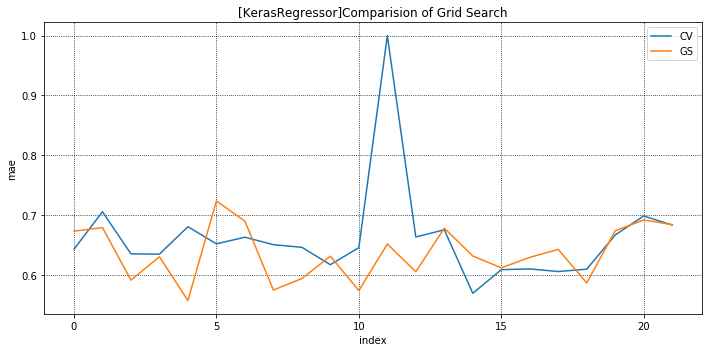

In [24]:
# グラフによるグリッドサーチ法有無の比較
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# グリッドサーチ法有無の比較(KerasRegressor)
ax.set_title('[KerasRegressor]Comparision of Grid Search')
ax.plot(kerasregressor_cv_mae.keys(), kerasregressor_cv_mae.values(), label='CV')
ax.plot(kerasregressor_gs_mae.keys(), kerasregressor_gs_mae.values(), label='GS')

ax.set_xlabel('index')
ax.set_ylabel('mae')
ax.grid(which='major', color='black', linestyle=':')
ax.grid(which='minor', color='black', linestyle=':')
ax.legend()

fig.tight_layout()
fig.show()

In [25]:
# cv,gsの最適値
min_cv_mae = {}
min_cv_model = {}
min_gs_mae = {}
min_gs_model = {}
best_gs_best_params = {}
best_gs_best_score = {}

for i in final_cv_mae:
    # クロスバリデーション法の最小値
    min_cv_mae[i] = min(final_cv_mae[i].values())
    min_cv_model[i] = [
        k for k, v in final_cv_mae[i].items() if v == min_cv_mae[i]
    ]

    # グリッドサーチ法の最小値
    min_gs_mae[i] = min(final_gs_mae[i].values())
    min_gs_model[i] = [
        k for k, v in final_gs_mae[i].items() if v == min_gs_mae[i]
    ]
    best_gs_best_params[i] = final_gs_best_params[i][min_gs_model[i][0]]
    best_gs_best_score[i] = final_gs_best_score[i][min_gs_model[i][0]]

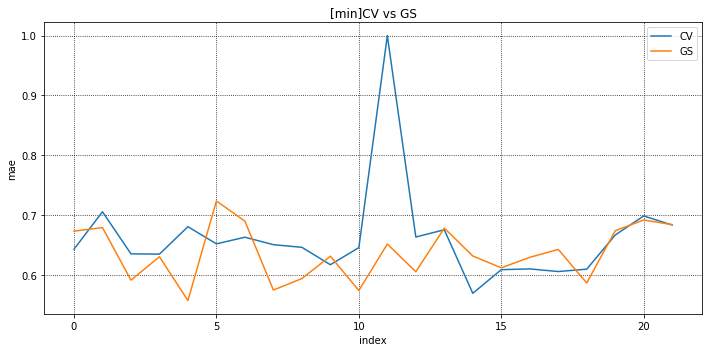

In [26]:
# グラフによる最適値確認
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# CVとGSの比較
ax.set_title('[min]CV vs GS')
ax.plot(min_cv_mae.keys(), 
           min_cv_mae.values(), label='CV')
ax.plot(min_gs_mae.keys(), 
           min_gs_mae.values(), label='GS')

ax.set_xlabel('index')
ax.set_ylabel('mae')
ax.grid(which='major', color='black', linestyle=':')
ax.grid(which='minor', color='black', linestyle=':')
ax.legend()

fig.tight_layout()
fig.show()

#### 定量評価

In [27]:
# normatl法の最適解
print('\n-----------------------------------')
print('<normal法>')

total_min_cv_mae = min(min_cv_mae.values())
total_cv_index = [k for k, v in min_cv_mae.items() if v == total_min_cv_mae]
total_min_cv_model = min_cv_model[total_cv_index[0]]

print('<クロスバリデーション法>')
print('index = {}'.format(total_cv_index[0]))
print('説明変数 = {}'.format(final_exp_data[total_cv_index[0]].index))
print("モデル = {}".format(total_min_cv_model))
print("MAE = {}".format(round(total_min_cv_mae, 3)))

total_min_gs_mae = min(min_gs_mae.values())
total_gs_index = [k for k, v in min_gs_mae.items() if v == total_min_gs_mae]
total_min_gs_model = min_gs_model[total_gs_index[0]]
total_best_gs_best_params = best_gs_best_params[total_gs_index[0]]
total_best_gs_best_score = best_gs_best_score[total_gs_index[0]]

print('\n<グリッドサーチ法>')
print('index = {}'.format(total_gs_index[0]))
print('説明変数 = {}'.format(final_exp_data[total_gs_index[0]].index))
print("モデル = {}".format(total_min_gs_model))
print("MAE = {}".format(round(total_min_gs_mae, 3)))
print("Grid Search best param = {}".format(total_best_gs_best_params))
print("Grid Search best score = {}".format(total_best_gs_best_score))


-----------------------------------
<normal法>
<クロスバリデーション法>
index = 14
説明変数 = Index(['[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')
モデル = ['KerasRegressor']
MAE = 0.569

<グリッドサーチ法>
index = 4
説明変数 = Index(['[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')
モデル = ['KerasRegressor']
MAE = 0.557
Grid Search best param = {}
Grid Search best score = -0.5329024871987394


In [28]:
# メモリ使用量確認
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                  df_data|     28040|
